# Interpretable Regression with RuleFit

+ Introduction
    + Install Packages
    + Custom Functions
    + Load California Dataset
+ Fit and evaluate RuleFit Model on Sine Function
+ Fit and evaluate RuleFit Model on Univariate Step Function
+ Multivariate Regression Problem with California Dataset
    + RuleFit Regressor Comparison with other Algorithms
    + Generated Rules Visualization & Interpretation
    + Explanations on Subsets of Predictions
    + Importance of Individual Features
    + RuleFit Regressor Over Maximum Rule hyperparameter
    
http://statweb.stanford.edu/~jhf/ftp/RuleFit.pdf

https://github.com/christophM/rulefit

In [91]:
#pip install git+git://github.com/christophM/rulefit.git

## Install Packages

In [92]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, make_scorer

from rulefit import RuleFit
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

from sklearn.datasets import fetch_california_housing

## Custom Functions

In [93]:
def find_mk(input_vars:list, rule:str):
    """
    Finds the number of input variables in a rule.
    
    Parameters:
    -----------
        input_vars (list): 
        
        rule (str):
    """
    var_count = 0
    for var in input_vars:
        if var in rule:
            var_count += 1
    return(var_count)

def get_feature_importance(feature_set: list, rule_set: pd.DataFrame, scaled = False):
    """
    Returns feature importance for input features to rulefit model.
    
    Parameters:
    -----------
        feature_set (list): 
        
        rule (str): 
    """
    feature_imp = list()
    
    rule_feature_count = rule_set.rule.apply(lambda x: find_mk(feature_set, x))

    for feature in feature_set:
        
        # find subset of rules that apply to a feature
        feature_rk = rule_set.rule.apply(lambda x: feature in x)
        
        # find importance of linear features
        linear_imp = rule_set[(rule_set.type=='linear')&(rule_set.rule==feature)].importance.values
        
        # find the importance of rules that contain feature
        rule_imp = rule_set.importance[feature_rk]
        
        # find the number of features in each rule that contain feature
        m_k = rule_feature_count[feature_rk]
        
        # sum the linear and rule importances, divided by m_k
        feature_imp.append(float(linear_imp + (rule_imp/m_k).sum()))
        
    if scaled:
        feature_imp = 100*(feature_imp/np.array(feature_imp).max())
    
    return(feature_imp)

## Load California Dataset

In [94]:
X, y = fetch_california_housing(return_X_y=True)
features = fetch_california_housing(return_X_y=False)['feature_names']
cali_data = pd.concat([pd.DataFrame(X, columns = [x.lower() for x in features]),pd.DataFrame(y, columns = ['medv'])],axis=1)

# Fit Models to a Sine Function

In [103]:
# Independed variable, range
X = np.arange(100).reshape(-1,1)

# Sine Function
y = [np.sin(x/8) for x in np.arange(100)]

# Fit a linear model using X as the independent variable
lreg = LinearRegression().fit(X,y)

# Record r2 score from linear model
lreg_score = np.round(lreg.score(X,y),2)

# Fit a RuleFit model using X as the independent variable and 100 rules max
rf = RuleFit(max_rules=250,random_state=1)
rf.fit(X, y, feature_names=['x'])
rules = rf.get_rules()

# Record r2 score from RuleFit model
rf_score = np.round(r2_score(rf.predict(X),y),2)

## Plot Results of Fitted Models on Test Function

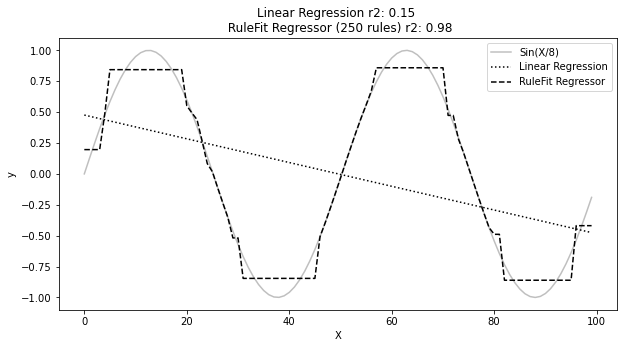

In [104]:
# Plot results
plt.figure(figsize=(10,5))
plt.title(f"Linear Regression r2: {lreg_score} \n RuleFit Regressor (250 rules) r2: {rf_score}")
plt.plot(y, label = 'Sin(X/8)', color = 'grey', alpha = 0.5)
plt.plot(lreg.predict(X), label = 'Linear Regression', color = 'k', linestyle = ':')
plt.plot(rf.predict(X), label = 'RuleFit Regressor', color = 'k', linestyle = '--')
plt.ylabel('y')
plt.xlabel('X')
plt.legend()
#plt.savefig('Sine_function_example.png')

# Fit and evaluate RuleFit Model on Univariate Step Function

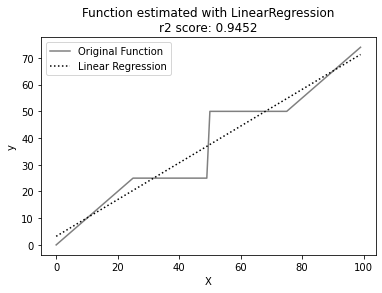

In [98]:
# Creating a step function
X = np.arange(100).reshape(-1,1)
y = [x for x in np.arange(25)] + [25]*25 + [50]*25 + [x+50 for x in np.arange(25)]

# Fit a linear model on the step function
lreg = LinearRegression()
lreg.fit(X,y)

# Record the r2 score
lreg_score = np.round(lreg.score(X,y),4)

# Plot the results
plt.plot(y, color = 'grey', label = 'Original Function')
plt.plot(lreg.predict(X), label = 'Linear Regression', color = 'k', linestyle = ":")
plt.title(f"Function estimated with LinearRegression\nr2 score: {lreg_score}")
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
#plt.savefig('linear_fit_step_function.png')

## RuleFit Regressor Interpretation

In [99]:
# Fit a RuleFit Regressor model with 1 rule
rf = RuleFit(max_rules=1,random_state=1)
rf.fit(X, y, feature_names=['X'])

# The get_rules method will return the top rules returned from the fitted model
rules = rf.get_rules()

# Display the top rules
rules = rules.sort_values("support", ascending=False)
print(rules)

                    rule    type       coef  support  importance
0                      X  linear   0.426891     1.00   12.259688
2               X > 49.5    rule  14.317238     0.44    7.106890
1   X <= 49.5 & X > 15.0    rule  -0.000000     0.34    0.000000
3  X <= 49.5 & X <= 15.0    rule  -5.262510     0.22    2.179975


**Explanation**

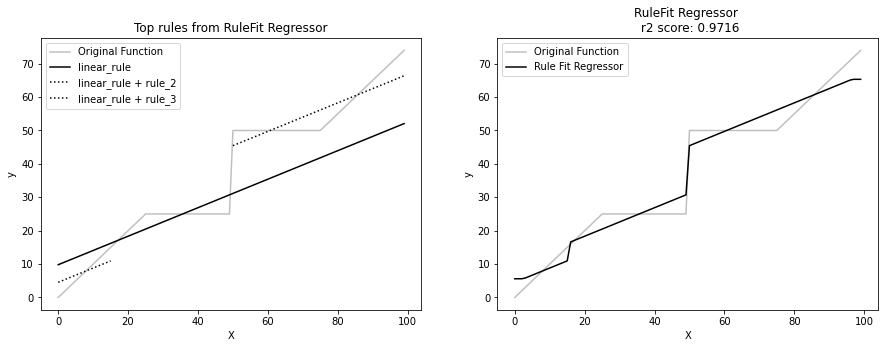

In [102]:
linear_rule = [rf.intercept_ + x*rules.loc[0]['coef'] for x in np.arange(100)]
rule_3= np.array(linear_rule) + rules.loc[3]['coef']
rule_2 = np.array(linear_rule) + rules.loc[2]['coef']


plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Top rules from RuleFit Regressor')
plt.plot(y, color = 'grey', label = 'Original Function', alpha = 0.5)
plt.plot(linear_rule, label = 'linear_rule', color = 'k')
plt.plot(pd.Series(rule_3)[0:16], label = 'linear_rule + rule_2', color = 'k', linestyle=':')
plt.plot(pd.Series(rule_2)[50:], label = 'linear_rule + rule_3', color = 'k', linestyle=':')
plt.ylabel('y')
plt.xlabel('X')
plt.legend()

plt.subplot(1,2,2)
plt.plot(y, color = 'grey', label = 'Original Function', alpha = 0.5)
plt.plot(rf.predict(X.reshape(-1,1)), color = 'k', label = 'Rule Fit Regressor')
plt.title(f"RuleFit Regressor \n r2 score: {np.round(r2_score(rf.predict(X,),y),4)}")
plt.ylabel('y')
plt.xlabel('X')
plt.legend()
#plt.savefig('linear_rule_fit_explained.png')

## RuleFit Regressor Performance Against Other Algorithms

In [57]:
y = cali_data.medv.values
X = cali_data.drop(["medv"], axis=1)
features = X.columns
X = X.to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 101)

In [78]:
model_dict = {
    'Gradient Boosted Regressor': GradientBoostingRegressor(),
    'Random Forest Regressor':RandomForestRegressor(),
    'Decision Tree Regressor':DecisionTreeRegressor(),
    'Linear Regression':LinearRegression(),
    'RuleFit Regressor':RuleFit(random_state = 101,max_rules = 500)
}

test_results = {}

for model in model_dict.keys():
    if model == 'RuleFit Regressor':
        model_dict[model].fit(X_train,y_train, feature_names = features)
    else:
        model_dict[model].fit(X_train,y_train)
    r2 = r2_score(model_dict[model].predict(X_test),y_test)
    test_results.update({model:np.round(r2,2)})

In [79]:
print("Results:")
print(pd.DataFrame(data = test_results.values(),
             index = test_results.keys(),
             columns = ['r2_score']).sort_values(by='r2_score',ascending=False))

Results:
                            r2_score
Random Forest Regressor         0.74
Gradient Boosted Regressor      0.70
RuleFit Regressor               0.65
Decision Tree Regressor         0.63
Linear Regression               0.31


## RuleFit Interpretations

In [80]:
rf = model_dict['RuleFit Regressor']
rules = rf.get_rules()

In [81]:
rules[rules.coef!=0].sort_values(by='importance', ascending=False).head(10)

,rule,type,coef,support,importance
7,longitude,linear,-0.385774,1.000000,0.752074
6,latitude,linear,-0.227418,1.000000,0.475680
289,longitude > -121.8650016784668 & latitude <= 3...,rule,0.763749,0.524138,0.381429
0,medinc,linear,0.208877,1.000000,0.351445
2,averooms,linear,0.082107,1.000000,0.099914
159,medinc <= 6.016050100326538 & aveoccup <= 3.09...,rule,0.473126,0.032184,0.083501
5,aveoccup,linear,-0.116393,1.000000,0.081009
417,houseage <= 49.5 & medinc <= 5.324949979782104...,rule,-0.192063,0.096552,0.056725
419,medinc <= 6.016050100326538 & aveoccup <= 3.09...,rule,0.094358,0.401149,0.046248
147,medinc <= 5.78220009803772 & houseage <= 19.5 ...,rule,-0.211958,0.048276,0.045433


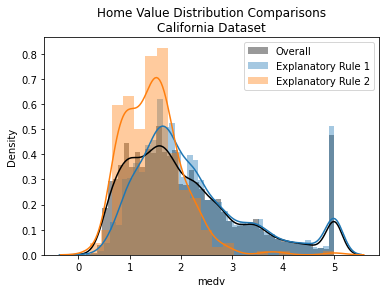

In [62]:
sns.distplot(cali_data.medv , color = 'k', label = 'Overall')
sns.distplot(cali_data.medv[(cali_data.longitude>-121)&(cali_data.latitude<=34.66)&(cali_data.latitude<=37.8)], label = 'Explanatory Rule 1')
sns.distplot(cali_data.medv[(cali_data.houseage<=49.5)&(cali_data.longitude>-117)*(cali_data.latitude<=37)&(cali_data.medinc>2.7)&(cali_data.medinc<=5.3)],label='Explanatory Rule 2')
plt.title('Home Value Distribution Comparisons\nCalifornia Dataset')
plt.legend()
#plt.savefig('distribution_comparison.png')

# Explanations on Subsets of Predictions
+ We'll look at two subregions of the population:
    + Samples in the upper 10% of median house values
    + Samples in the lower 10% of median house values

In [82]:
subregion1 = cali_data[cali_data.medv>=np.quantile(cali_data.medv,0.9)].drop('medv',axis=1)
subregion2 = cali_data[cali_data.medv<=np.quantile(cali_data.medv,0.1)].drop('medv',axis=1)

**Top Rules for Homes with a Median Value in top 10%**

The top 10% of median values of homes have these rules in common. Linear relationships dominate, but there are a few other, more detailed rules that describe the homes with high values in California. Notice the rules that take into account income and occupation.

In [83]:
rf.get_rules(subregion = subregion1.to_numpy()).sort_values(by='importance', ascending=False).head(10)

,rule,type,coef,support,importance
7,longitude,linear,-0.385774,1.000000,0.716305
0,medinc,linear,0.208877,1.000000,0.544974
6,latitude,linear,-0.227418,1.000000,0.413258
289,longitude > -121.8650016784668 & latitude <= 3...,rule,0.763749,0.524138,0.378020
2,averooms,linear,0.082107,1.000000,0.119376
5,aveoccup,linear,-0.116393,1.000000,0.063047
159,medinc <= 6.016050100326538 & aveoccup <= 3.09...,rule,0.473126,0.032184,0.057009
79,houseage > 27.5 & medinc > 5.704449892044067,rule,0.132722,0.047126,0.048847
211,houseage > 20.5 & medinc > 3.5364999771118164 ...,rule,0.104027,0.164368,0.048025
121,houseage > 26.5 & medinc > 5.57420015335083,rule,0.117401,0.066667,0.046831


In [87]:
rf.get_rules(subregion = subregion1.to_numpy()).sort_values(by='importance', ascending=False).head(10).loc[159].rule

'medinc <= 6.016050100326538 & aveoccup <= 3.0983457565307617 & latitude <= 37.81500053405762 & longitude <= -122.28499984741211'

**Top Rules for Homes with a Median Value in top 10%**

Similarly for low median value homes, there are a couple linear relationships that are importance, but we can still see some interesting rules.

In [88]:
rf.get_rules(subregion = subregion2.to_numpy()).sort_values(by='importance', ascending=False).head(10)

,rule,type,coef,support,importance
7,longitude,linear,-0.385774,1.000000,0.583019
6,latitude,linear,-0.227418,1.000000,0.446598
289,longitude > -121.8650016784668 & latitude <= 3...,rule,0.763749,0.524138,0.393582
0,medinc,linear,0.208877,1.000000,0.354490
5,aveoccup,linear,-0.116393,1.000000,0.067206
2,averooms,linear,0.082107,1.000000,0.062976
257,medinc <= 4.5358500480651855 & medinc <= 2.985...,rule,-0.076442,0.210345,0.046238
419,medinc <= 6.016050100326538 & aveoccup <= 3.09...,rule,0.094358,0.401149,0.043585
172,medinc <= 2.7482000589370728 & averooms > 3.53...,rule,-0.067468,0.273563,0.043066
343,medinc <= 6.58144998550415 & medinc > 2.543049...,rule,-0.073094,0.620690,0.041338


In [89]:
rf.get_rules(subregion = subregion2.to_numpy()).sort_values(by='importance', ascending=False).head(10).loc[257].rule

'medinc <= 4.5358500480651855 & medinc <= 2.985849976539612 & averooms > 4.3484015464782715'

# Importance of Individual Features

Either over the entire population of samples, or a subset of samples, the importance of individual features can be found.  According to formula # 35, the importance takes into consideration.

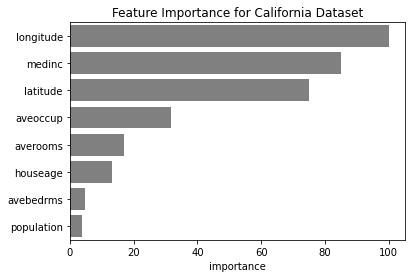

In [66]:
feature_importances = get_feature_importance(cali_data.columns[0:-1], rf.get_rules(), scaled=True)

importance_df = pd.DataFrame(feature_importances, index = cali_data.columns[0:-1], columns = ['importance']).sort_values(by='importance',ascending=False)

sns.barplot(x = importance_df.importance, y = importance_df.index, color = 'grey')
plt.title('Feature Importance for California Dataset')
#plt.savefig('feature_importance.png')

## RuleFit Regressor Over Maximum Rule hyperparameter

Here, we can see the effectiveness of increasing the maximum rules parameter for the RuleFit Regressor. There is a threat of overfitting with this parameter. Usually, increasing the complexity of the model leads to overfitting.

In [74]:
rf = RuleFit(random_state=1)

max_rules_list = np.arange(50,1050,50)
parameters = {'max_rules':max_rules_list}

r2_scorer = make_scorer(r2_score)
rfgs = GridSearchCV(rf, parameters, scoring = r2_scorer, cv = 5, return_train_score=True)

rfgs = rfgs.fit(X,y)

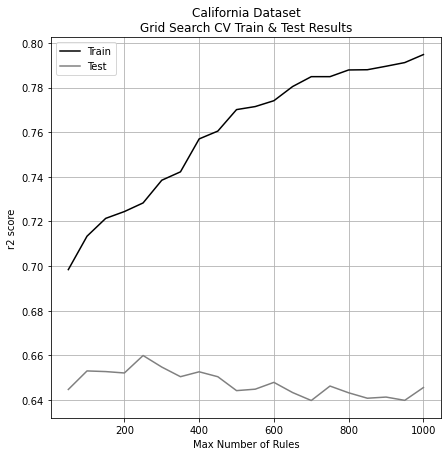

In [75]:
plt.figure(figsize=(7,7))
sns.lineplot(x = max_rules_list, y=rfgs.cv_results_['mean_train_score'], label = 'Train', color = 'k')
sns.lineplot(x = max_rules_list, y=rfgs.cv_results_['mean_test_score'], label = 'Test', color = 'grey')
plt.xlabel('Max Number of Rules')
plt.ylabel('r2 score')
plt.title('California Dataset\nGrid Search CV Train & Test Results')
plt.grid()
plt.legend()
plt.savefig('grid_search_cv_results.png')

# END